In [89]:
# === Cell 0 — Quick Start (Sidekick / Stage-3) ===============================
# Goal: run standardized, deterministic eval across many models (4q & 6q).
# This notebook expects *Sidekick/Stage-3* bundles with:
#   parameters.psi_stage3  (student encoder, flat vector)
#   parameters.phi_stage1  (teacher encoder, flat vector) → decoder = adjoint(teacher)
#
# ── 1) Choose where your model JSONs live ────────────────────────────────────
#    You have two options:
#      A. Auto-discover: point ROOTS to directories; we scan for **/model_bundle.json
#      B. Manual: fill MODEL_PATHS by hand (name -> absolute path)
#
#    We *also* support standardized filenames like:
#      4q_2l_2t_3ls_01.json     # (nq=4, n_latent=2, n_trash=2, n_layers=3, instance #1)
#    If you name files that way, we’ll parse meta from the filename if the JSON lacks it.

import os, glob

# Option A: folders to scan (recursive) for "model_bundle.json" files.
ROOTS = [
    # "/path/to/model1/",
    # "/path/to/model2/",
]

# Auto-discover pattern relative to each ROOT folder
DISCOVER_PATTERN = "**/model_bundle.json"

# Option B: manual mapping (name -> path). ← Your current model left here.
MODEL_PATHS = {
    "Me_run_20250824_nq4_s010":
        "model_bundle.json",
    # "4q_2l_2t_1ls_01": "/abs/path/to/4q_2l_2t_1ls_01.json",
    # "6q_4l_2t_3ls_07": "/abs/path/to/6q_4l_2t_3ls_07.json",
}

def _discover_models(roots, pattern=DISCOVER_PATTERN):
    d = {}
    for r in roots:
        for p in glob.glob(os.path.join(r, pattern), recursive=True):
            tag = os.path.basename(os.path.dirname(p))  # folder name as default tag
            base = tag; k = 1
            while tag in d:
                k += 1; tag = f"{base}_{k}"
            d[tag] = os.path.abspath(p)
    return d

if ROOTS:
    auto = _discover_models(ROOTS)
    # Prefer manual names; add discovered ones that don't collide
    for k,v in auto.items():
        if k not in MODEL_PATHS:
            MODEL_PATHS[k] = v

print(f"Models registered: {len(MODEL_PATHS)}")

# ── 2) Choose evaluation sigma ───────────────────────────────────────────────
#    "model" → use each model's own train sigma from its JSON
#    or set a number like 0.075 or 0.10 to force one sigma for all models.
EVAL_SIGMA = 0.1

# ── 3) Evaluation budget (per dataset) ───────────────────────────────────────
N_EVAL_WINDOWS = 20   # per model per dataset (test-split windows)

# ── 4) What you (or your friend) MUST edit later ─────────────────────────────
#    In Cell 3, there is a tiny section marked:
#      >>> YOUR CIRCUIT ANSATZ HERE <<<
#    Replace the RX/RY/RZ+ring brick with your own encoder.
#    The decoder is always adjoint(teacher_encoder), so just mirror the same topology there.

# ── 5) Run all cells *from top to bottom*. The notebook will:
#    - Build deterministic MG_A/MG_B datasets for window sizes 4 and 6
#    - Load models (your path above + anything discovered)
#    - Print each model’s architecture summary (qubits / latent / trash / layers)
#    - Benchmark and produce plots (per-window Δ%, robustness, full-series, panels, error lens)

Models registered: 1


In [81]:
# === Cell 1 — Imports & utilities ===========================================
import os, re, json, math, time, hashlib, warnings, glob
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp

np.set_printoptions(suppress=True, precision=6)
plt.rcParams["figure.figsize"] = (6.8, 4.2)

# ---------- scaling & angles ----------
def values_to_v01(v, low, high):
    v = np.asarray(v, dtype=float); return (v - low) / max(1e-12, (high - low))

def v01_to_values(v01, low, high):
    v01 = np.asarray(v01, dtype=float); return low + v01 * (high - low)

def readoutZ_to_values(z, low, high):
    z = np.clip(np.asarray(z, dtype=float), -0.999999, 0.999999)
    v01 = np.arccos(z) / np.pi
    return v01_to_values(v01, low, high)

def values_to_RY_angles(v, low, high):
    return np.pi * values_to_v01(v, low, high)

# ---------- deterministic noise ----------
def _stable_seed(tag: str) -> int:
    h = hashlib.sha256(tag.encode("utf-8")).digest()
    return int.from_bytes(h[:8], "little") & 0x7FFFFFFF

def add_gaussian_noise_series(series, sigma, low, high, seed):
    rng = np.random.default_rng(seed)
    noise = rng.normal(0.0, sigma * (high - low), size=series.shape)
    x = np.clip(series + noise, low, high)
    return x

# ---------- stats ----------
def bootstrap_ci_mean(x, B=3000, alpha=0.05, rng=None):
    x = np.asarray(x, dtype=float)
    if x.size == 0: return (np.nan, np.nan, np.nan)
    rng = np.random.default_rng(None if rng is None else rng)
    n = x.size
    xb = np.empty(B, float)
    for b in range(B):
        idx = rng.integers(0, n, size=n)
        xb[b] = np.mean(x[idx])
    xb.sort()
    lo = xb[int((alpha/2)*B)]
    hi = xb[int((1 - alpha/2)*B) - 1]
    return float(np.mean(x)), float(lo), float(hi)

def sign_test_pvalue(diffs):
    diffs = np.asarray(diffs, dtype=float)
    wins  = int(np.sum(diffs > 0))
    losses= int(np.sum(diffs < 0))
    n     = wins + losses
    if n == 0: return 1.0
    tail = sum(math.comb(n, k) for k in range(0, min(wins, losses)+1)) / (2**n)
    return float(min(1.0, 2*tail))

In [82]:
# === Cell 2 — Standardized datasets (for window sizes 4 & 6) ================
NOISE_GRID = (EVAL_SIGMA,) 

def mackey_glass(length=1300, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    x = np.zeros(length + tau + 1, dtype=float); x[:tau+1] = x0
    for t in range(tau, length + tau):
        xt = x[t]; xt_tau = x[t - tau]
        dx = beta * xt_tau / (1.0 + xt_tau**n) - gamma * xt
        x[t+1] = xt + dx
    return x[tau+1:]

def scale_to_range(y, low=0.2, high=0.8):
    y = np.asarray(y, dtype=float)
    ymin, ymax = float(y.min()), float(y.max())
    if ymax - ymin < 1e-12: return np.full_like(y, (low+high)/2), (low, high)
    z = (y - ymin) / (ymax - ymin)
    return low + z * (high - low), (low, high)

def make_windows(ts, size, step):
    ts = np.asarray(ts, dtype=float)
    return np.array([ts[i:i+size] for i in range(0, len(ts)-size+1, step)], dtype=float)

@dataclass
class Dataset:
    name: str
    clean: np.ndarray
    scale_low: float
    scale_high: float
    windows_clean: np.ndarray
    split_idx: int
    noisy_series_by_sigma: dict
    noisy_windows_by_sigma: dict

def _build_for_window_size(window_size=4, window_step=1, noise_grid=NOISE_GRID):
    mgA = mackey_glass(length=1300, tau=17)
    mgB = mackey_glass(length=1300, tau=30)
    sA,(loA,hiA) = scale_to_range(mgA, 0.2, 0.8)
    sB,(loB,hiB) = scale_to_range(mgB, 0.2, 0.8)
    winA = make_windows(sA, window_size, window_step)
    winB = make_windows(sB, window_size, window_step)
    splitA = int(0.75 * len(winA)); splitB = int(0.75 * len(winB))

    def make_maps(name, scaled, lo, hi):
        series_map, win_map = {}, {}
        for sigma in noise_grid:
            seed = _stable_seed(f"{name}|sigma={sigma:.3f}|W={window_size}")
            noisy = add_gaussian_noise_series(scaled, sigma, lo, hi, seed)
            series_map[round(sigma,3)] = noisy
            win_map[round(sigma,3)] = make_windows(noisy, window_size, window_step)
        return series_map, win_map

    nsA_s, nsA_w = make_maps("MG_A", sA, loA, hiA)
    nsB_s, nsB_w = make_maps("MG_B", sB, loB, hiB)

    return {
        "MG_A": Dataset("MG_A", sA, loA, hiA, winA, splitA, nsA_s, nsA_w),
        "MG_B": Dataset("MG_B", sB, loB, hiB, winB, splitB, nsB_s, nsB_w),
    }

DATASETS_BY_W = {
    4: _build_for_window_size(4, 1, NOISE_GRID),
    6: _build_for_window_size(6, 1, NOISE_GRID),
}
print("Datasets ready for window sizes:", list(DATASETS_BY_W))

Datasets ready for window sizes: [4, 6]


In [83]:
# === Cell 3 — Sidekick class (Stage-3, fixed decoder = adjoint(teacher)) ====
class Stage3FixedDecoderQAE:
    """
    Input embedding: RY(pi * v01(values)) per qubit.
    Encoder (student): E_psi — YOUR ANSATZ HERE (default RX/RY/RZ + ring CNOT).
    Decoder (fixed):   D = adjoint(E_phi) — must mirror *the same* topology.
    Readout: expZ on all wires → arccos mapping back to [low,high] values.

    Exposes:
      - forward_expZ(values_window)            → expZ after full pipeline
      - latents_after_encoder_expZ(values)     → expZ on latent wires after E_psi
      - trash_probs_after_encoder(values)      → probs over trash wires after E_psi
      - predict_values(values)                 → value-domain reconstruction
      - describe()                             → prints architecture summary
    """
    def __init__(self, *, n_qubits, n_layers, n_latent=2, trash_wires=None,
                 scale_low=0.2, scale_high=0.8,
                 psi_flat: np.ndarray, theta_fixed: np.ndarray):
        self.n_qubits=int(n_qubits); self.n_layers=int(n_layers)
        self.n_latent=int(n_latent)
        self.latent_wires=list(range(self.n_latent))
        self.trash_wires=list(trash_wires) if trash_wires is not None else list(range(self.n_latent, self.n_qubits))
        self.scale_low=float(scale_low); self.scale_high=float(scale_high)

        self.psi = pnp.asarray(np.asarray(psi_flat, dtype=float).ravel(), requires_grad=False)
        self.theta_fixed = pnp.asarray(np.asarray(theta_fixed, dtype=float).reshape(self.n_layers, self.n_qubits, 3),
                                       requires_grad=False)

        self.dev = qml.device("default.qubit", wires=self.n_qubits)
        self._q_fwd=None; self._q_lat=None; self._q_trash=None

    # --- >>> YOUR CIRCUIT ANSATZ HERE (encoder & decoder) <<< -----------------
    # Replace the RX/RY/RZ+ring with your template.
    def _enc_student(self, flat):
        L,Q=self.n_layers,self.n_qubits; fp=flat
        for l in range(L):
            for q in range(Q):
                i=l*Q*3+q*3
                qml.RX(fp[i+0],wires=q); qml.RY(fp[i+1],wires=q); qml.RZ(fp[i+2],wires=q)
            for q in range(Q-1): qml.CNOT(wires=[q,q+1])
            qml.CNOT(wires=[Q-1,0])

    def _enc_teacher_body(self, theta):
        L,Q=self.n_layers,self.n_qubits; T=theta
        for l in range(L):
            for q in range(Q):
                qml.RX(T[l,q,0],wires=q); qml.RY(T[l,q,1],wires=q); qml.RZ(T[l,q,2],wires=q)
            for q in range(Q-1): qml.CNOT(wires=[q,q+1])
            qml.CNOT(wires=[Q-1,0])
    # --------------------------------------------------------------------------

    def _dec_fixed(self):  # D = E_phi^\dagger
        qml.adjoint(self._enc_teacher_body)(self.theta_fixed)

    def _embed(self, values):
        for i, th in enumerate(values_to_RY_angles(values, self.scale_low, self.scale_high)):
            qml.RY(float(th), wires=i)

    def _build_forward(self):
        @qml.qnode(self.dev, diff_method=None)
        def qnode(values_window):
            self._embed(values_window); self._enc_student(self.psi); self._dec_fixed()
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]
        return qnode

    def _build_lat(self):
        @qml.qnode(self.dev, diff_method=None)
        def qnode(values_window):
            self._embed(values_window); self._enc_student(self.psi)
            return [qml.expval(qml.PauliZ(i)) for i in self.latent_wires]
        return qnode

    def _build_trash(self):
        @qml.qnode(self.dev, diff_method=None)
        def qnode(values_window):
            self._embed(values_window); self._enc_student(self.psi)
            return qml.probs(wires=self.trash_wires)
        return qnode

    # Framework API
    def forward_expZ(self, values_window):
        if self._q_fwd is None: self._q_fwd=self._build_forward()
        return np.asarray(self._q_fwd(values_window), dtype=float)

    def latents_after_encoder_expZ(self, values_window):
        if self._q_lat is None: self._q_lat=self._build_lat()
        return np.asarray(self._q_lat(values_window), dtype=float)

    def trash_probs_after_encoder(self, values_window):
        if self._q_trash is None: self._q_trash=self._build_trash()
        return np.asarray(self._q_trash(values_window), dtype=float)

    def map_expZ_to_values(self, z_all):
        return readoutZ_to_values(z_all, self.scale_low, self.scale_high)

    def predict_values(self, values_window):
        return self.map_expZ_to_values(self.forward_expZ(values_window))

    def describe(self):
        print(f"QAE Sidekick — nq={self.n_qubits}, layers={self.n_layers}, "
              f"latent={self.n_latent}, trash={len(self.trash_wires)} "
              f"({self.trash_wires}), scale=[{self.scale_low},{self.scale_high}]")

In [84]:
# === Cell 4 — Loader (schema-flexible + standardized filename parsing) =======
# EXPECTED BUNDLE (sidekick):
#   parameters:
#     - psi_stage3 : flat vector for Stage-3 noisy encoder E_ψ   (shape = L*Q*3) 
#     - phi_stage1 : flat vector for Stage-1 clean encoder     E_φ       (shape = L*Q*3)
#   We construct the fixed decoder for Stage-3 as D = adjoint(E_φ).

def _sha256_params(obj):
    buf = bytearray()
    def walk(x):
        if isinstance(x, (list, tuple)):
            for y in x: walk(y)
        elif isinstance(x, np.ndarray):
            buf.extend(np.ascontiguousarray(x, dtype=np.float64).tobytes())
        elif isinstance(x, (float, int, np.floating, np.integer)):
            buf.extend(np.asarray([x], dtype=np.float64).tobytes())
        else:
            buf.extend(str(x).encode("utf-8"))
    walk(obj)
    return hashlib.sha256(buf).hexdigest()

# Standardized filename pattern:  4q_2l_2t_3ls_01.json
_STD_RE = re.compile(r"(?P<nq>\d+)q_(?P<nl>\d+)l_(?P<nt>\d+)t_(?P<L>\d+)ls_(?P<inst>\d+)\.json$", re.IGNORECASE)

def parse_std_filename(path):
    m = _STD_RE.search(os.path.basename(path))
    if not m: return None
    d = {k:int(v) for k,v in m.groupdict().items()}
    return {"n_qubits": d["nq"], "n_latent": d["nl"], "n_trash": d["nt"], "n_layers": d["L"], "instance": d["inst"]}

@dataclass
class ModelEntry:
    name: str
    path: str
    n_qubits: int
    n_latent: int
    trash_wires: list
    scale_low: float
    scale_high: float
    noise_sigma_train: float
    meta: dict
    params: dict
    fingerprint: str
    impl: object

def parse_model_json_sidekick(path):
    with open(path, "r", encoding="utf-8") as f:
        J = json.load(f)

    # Preferred schema:
    if "parameters" in J and "psi_stage3" in J["parameters"] and "phi_stage1" in J["parameters"]:
        P = J["parameters"]
        psi = np.asarray(P["psi_stage3"], dtype=float).ravel()
        phi = np.asarray(P["phi_stage1"], dtype=float).ravel()

        arch = J.get("architecture", {})
        ds   = J.get("dataset", {})
        run  = J.get("run", {})

        # If meta missing, try filename
        fn_meta = parse_std_filename(path) or {}
        n_qubits = int(arch.get("n_qubits", ds.get("window_size", fn_meta.get("n_qubits", 4))))
        if psi.size % (n_qubits*3) != 0:
            raise ValueError(f"psi_stage3 length {psi.size} not divisible by n_qubits*3={n_qubits*3}")
        n_layers = int(arch.get("n_layers", fn_meta.get("n_layers", psi.size // (n_qubits*3))))
        n_latent = int(arch.get("n_latent", fn_meta.get("n_latent", max(1, n_qubits//2))))
        n_trash  = int(arch.get("n_trash",  fn_meta.get("n_trash", n_qubits - n_latent)))
        trash_wires = arch.get("trash_wires", list(range(n_latent, n_qubits)))
        scale_low  = float(ds.get("scale_low", 0.2))
        scale_high = float(ds.get("scale_high", 0.8))
        theta_fixed = phi.reshape(n_layers, n_qubits, 3)

        info = {
            "n_qubits": n_qubits, "n_layers": n_layers,
            "n_latent": n_latent, "trash_wires": list(trash_wires),
            "scale_low": scale_low, "scale_high": scale_high,
            "noise_sigma_train": float(run.get("sigma_train", np.nan)),
            "source_schema": "sidekick_bundle",
            "n_trash": n_trash,
        }
        return {"psi": psi, "theta_fixed": theta_fixed, "info": info}

    raise ValueError("Unsupported JSON schema: expected parameters.psi_stage3 & parameters.phi_stage1.")

def instantiate_model_sidekick(parsed):
    i=parsed["info"]
    impl = Stage3FixedDecoderQAE(
        n_qubits=i["n_qubits"], n_layers=i["n_layers"],
        n_latent=i["n_latent"], trash_wires=i["trash_wires"],
        scale_low=i["scale_low"], scale_high=i["scale_high"],
        psi_flat=parsed["psi"], theta_fixed=parsed["theta_fixed"]
    )
    return impl

def load_models_sidekick(model_paths: dict):
    registry = {}
    for name, path in model_paths.items():
        try:
            P = parse_model_json_sidekick(path)
            impl = instantiate_model_sidekick(P)
            fp = _sha256_params([P["psi"], P["theta_fixed"]])
            i = P["info"]
            entry = ModelEntry(
                name=name, path=path, n_qubits=i["n_qubits"], n_latent=i["n_latent"],
                trash_wires=list(i["trash_wires"]), scale_low=i["scale_low"], scale_high=i["scale_high"],
                noise_sigma_train=float(i["noise_sigma_train"]), meta=i,
                params={"psi_flat": P["psi"], "theta_fixed": P["theta_fixed"]},
                fingerprint=fp, impl=impl
            )
            registry[name] = entry
            print(f"✓ Loaded {name}  (nq={entry.n_qubits}, L={i['n_layers']}, "
                  f"latent={entry.n_latent}, trash={len(entry.trash_wires)}, σ_train={entry.noise_sigma_train:g})")
            impl.describe()
        except Exception as e:
            print(f"✗ {name}: {e}")
    return registry

print("Sidekick loader ready.")

Sidekick loader ready.


In [85]:
# === Cell 5 — Evaluation core ===============================================
@dataclass
class EvalResult:
    noisy_mse: np.ndarray
    model_mse: np.ndarray
    delta_pct: np.ndarray
    delta_pct_sym: np.ndarray
    recon_values: np.ndarray
    noisy_values: np.ndarray
    clean_values: np.ndarray
    lat_clean: np.ndarray|None
    lat_noisy: np.ndarray|None
    p00_trash: np.ndarray|None

def _sigma_key(s): return float(np.round(float(s), 3))

def _pick_sigma(entry, override):
    return float(entry.noise_sigma_train) if (override == "model") else float(override)

def eval_model_on_dataset(entry, ds, n_eval=20, sigma_override="model"):
    s = _pick_sigma(entry, sigma_override)
    s_key = _sigma_key(s)
    if s_key not in ds.noisy_windows_by_sigma:
        available = ", ".join([f"{k:.3f}" for k in sorted(ds.noisy_windows_by_sigma.keys())])
        raise ValueError(f"{ds.name}: σ={s_key:.3f} not in [{available}]")
    cleanW = ds.windows_clean[ds.split_idx:]
    noisyW = ds.noisy_windows_by_sigma[s_key][ds.split_idx:]
    N = min(int(n_eval), len(cleanW))
    cleanW = cleanW[:N]; noisyW = noisyW[:N]

    impl = entry.impl
    recon=[]; nmse=[]; dmse=[]; d_pct=[]; d_sym=[]
    lat_c, lat_n, p00 = [], [], []

    for w_clean, w_noisy in zip(cleanW, noisyW):
        z = impl.forward_expZ(w_noisy)
        y = impl.map_expZ_to_values(z)
        recon.append(y)
        mse_n = float(np.mean((w_clean - w_noisy)**2))
        mse_d = float(np.mean((w_clean - y)**2))
        nmse.append(mse_n); dmse.append(mse_d)
        d_pct.append(0.0 if mse_n<1e-12 else 100.0 * (mse_n - mse_d) / mse_n)
        d_sym.append(200.0 * (mse_n - mse_d) / max(mse_n + mse_d, 1e-12))

        try:
            lc = impl.latents_after_encoder_expZ(w_clean)
            ln = impl.latents_after_encoder_expZ(w_noisy)
            lat_c.append(lc); lat_n.append(ln)
        except Exception:
            lat_c = lat_n = None
        try:
            P = impl.trash_probs_after_encoder(w_noisy); p00.append(float(P[0]))
        except Exception:
            p00 = None

    return EvalResult(
        noisy_mse=np.asarray(nmse), model_mse=np.asarray(dmse),
        delta_pct=np.asarray(d_pct), delta_pct_sym=np.asarray(d_sym),
        recon_values=np.asarray(recon), noisy_values=noisyW, clean_values=cleanW,
        lat_clean=None if lat_c is None else np.asarray(lat_c),
        lat_noisy=None if lat_n is None else np.asarray(lat_n),
        p00_trash=None if p00 is None else np.asarray(p00)
    )

def summarize_eval(er):
    mean_imp, lo_imp, hi_imp = bootstrap_ci_mean(er.delta_pct)
    mean_sym, lo_sym, hi_sym = bootstrap_ci_mean(er.delta_pct_sym)
    p_val = sign_test_pvalue(er.noisy_mse - er.model_mse)
    succ  = 100.0 * float(np.mean(er.delta_pct > 0))
    return {
        "noisy_MSE_mean": float(np.mean(er.noisy_mse)),
        "model_MSE_mean": float(np.mean(er.model_mse)),
        "delta_pct_mean": float(mean_imp),
        "delta_pct_CI95": [float(lo_imp), float(hi_imp)],
        "delta_pct_sym_mean": float(mean_sym),
        "delta_pct_sym_CI95": [float(lo_sym), float(hi_sym)],
        "sign_test_p": float(p_val),
        "success_rate_pct": float(succ),
        "n_windows": int(er.noisy_mse.size)
    }

In [86]:
# === Cell 6 — Plotting & extra analytics ====================================
def plot_reconstruction_example(er: EvalResult, idx=0, title="Reconstruction"):
    c,n,d = er.clean_values[idx], er.noisy_values[idx], er.recon_values[idx]
    xs = np.arange(len(c)); plt.figure()
    plt.plot(xs, c, label="clean"); plt.plot(xs, n, label="noisy"); plt.plot(xs, d, label="denoised")
    plt.title(title); plt.xlabel("t"); plt.ylabel("value"); plt.legend(); plt.show()

def plot_delta_distributions(er_by_model, title="ΔMSE% (per-window)"):
    plt.figure()
    for name, er in er_by_model.items(): plt.hist(er.delta_pct, bins=12, alpha=0.5, label=name)
    plt.title(title); plt.xlabel("improvement %"); plt.ylabel("count"); plt.legend(); plt.show()

def plot_robustness(entry, ds, sigmas=(0.05,0.075,0.10), n_eval=20):
    means,lows,highs=[],[],[]
    for s in sigmas:
        er = eval_model_on_dataset(entry, ds, n_eval=n_eval, sigma_override=s)
        m,lo,hi = bootstrap_ci_mean(er.delta_pct); means.append(m); lows.append(lo); highs.append(hi)
    plt.figure(); plt.plot(sigmas, means, marker="o"); plt.fill_between(sigmas, lows, highs, alpha=0.2)
    plt.xlabel("σ"); plt.ylabel("ΔMSE% (mean, 95%CI)"); plt.title(f"Robustness on {ds.name} — {entry.name}"); plt.show()

def plot_latent_trash(er, entry, dsname):
    if er.lat_clean is not None and er.lat_noisy is not None:
        diffs = np.mean((er.lat_clean - er.lat_noisy)**2, axis=1)
        plt.figure(); plt.hist(diffs, bins=12)
        plt.title(f"Latent drift MSE — {entry.name} on {dsname}"); plt.xlabel("MSE"); plt.ylabel("count"); plt.show()
    if er.p00_trash is not None:
        plt.figure(); plt.hist(er.p00_trash, bins=12)
        plt.title(f"Trash P(|00⟩) after encoder — {entry.name} on {dsname}")
        plt.xlabel("P00"); plt.ylabel("count"); plt.show()

# Tables & heatmaps
def summaries_to_df(all_summaries, registry):
    rows=[]
    for dsname, bymodel in all_summaries.items():
        for name, sm in bymodel.items():
            e = registry[name]
            rows.append({
                "dataset": dsname, "model": name,
                "n_qubits": e.n_qubits, "n_latent": e.n_latent, "n_trash": len(e.trash_wires),
                "layers": e.meta.get("n_layers", e.params["psi_flat"].size // (e.n_qubits*3)),
                "delta_pct_mean": sm["delta_pct_mean"],
                "delta_pct_lo": sm["delta_pct_CI95"][0],
                "delta_pct_hi": sm["delta_pct_CI95"][1],
                "success_rate_pct": sm["success_rate_pct"],
                "p": sm["sign_test_p"],
            })
    return pd.DataFrame(rows)

def heatmap_by_arch(df, dataset, value_col="delta_pct_mean"):
    sub = df[df["dataset"]==dataset]
    for (nl, nt), group in sub.groupby(["n_latent","n_trash"]):
        piv = group.pivot_table(index="n_qubits", columns="layers", values=value_col, aggfunc="mean")
        plt.figure(figsize=(5.2,3.6)); plt.imshow(piv.values, aspect="auto")
        plt.xticks(range(piv.shape[1]), piv.columns); plt.yticks(range(piv.shape[0]), piv.index)
        plt.colorbar(label=value_col); plt.title(f"{dataset} — mean {value_col} (latent={nl}, trash={nt})")
        plt.xlabel("layers"); plt.ylabel("n_qubits"); plt.tight_layout(); plt.show()

# Full-series tools
def _flatten_avg(windows, step):
    N,W = windows.shape; L=(N-1)*step+W
    acc=np.zeros(L); cnt=np.zeros(L)
    for i in range(N): s=i*step; e=s+W; acc[s:e]+=windows[i]; cnt[s:e]+=1
    return acc/np.maximum(cnt,1e-12)

def reconstruct_full_series(entry, ds, sigma_override="model", step=1):
    s = _pick_sigma(entry, sigma_override); s_key=_sigma_key(s)
    cleanW = np.asarray(ds.windows_clean, dtype=float)
    noisyW = np.asarray(ds.noisy_windows_by_sigma[s_key], dtype=float)
    preds = [entry.impl.map_expZ_to_values(entry.impl.forward_expZ(w)) for w in noisyW]
    preds = np.asarray(preds)
    flat_c=_flatten_avg(cleanW, step); flat_n=_flatten_avg(noisyW, step); flat_d=_flatten_avg(preds, step)
    mse_n=float(np.mean((flat_c-flat_n)**2)); mse_d=float(np.mean((flat_c-flat_d)**2))
    d_pct=0.0 if mse_n<1e-12 else 100.0*(mse_n-mse_d)/mse_n
    return {"clean":flat_c,"noisy":flat_n,"deno":flat_d,"mse_noisy":mse_n,"mse_deno":mse_d,"delta_pct":d_pct,"sigma":s_key}

def plot_full_series(rec, title):
    L=len(rec["clean"]); xs=np.arange(L)
    plt.figure(figsize=(9.8,4.0))
    plt.plot(xs, rec["clean"], label="clean")
    plt.plot(xs, rec["noisy"], label=f"noisy (MSE={rec['mse_noisy']:.5f})")
    plt.plot(xs, rec["deno"],  label=f"deno (MSE={rec['mse_deno']:.5f}, Δ%={rec['delta_pct']:+.1f})")
    plt.xlabel("t"); plt.ylabel("value"); plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

def plot_full_series_panels(entry, ds, sigma_override="model", panel_len=180, ncols=3, nrows=2, start=0, sharey=True):
    rec = reconstruct_full_series(entry, ds, sigma_override)
    c,n,d = rec["clean"], rec["noisy"], rec["deno"]; L=len(c)
    fig,axes = plt.subplots(nrows, ncols, figsize=(4.5*ncols,2.75*nrows), sharey=sharey)
    axes=np.ravel(axes)
    for k,ax in enumerate(axes):
        s = start + k*panel_len; e=min(s+panel_len, L)
        if s>=L: ax.axis("off"); continue
        xs=np.arange(s,e); cc=c[s:e]; nn=n[s:e]; dd=d[s:e]
        mse_n=float(np.mean((cc-nn)**2)); mse_d=float(np.mean((cc-dd)**2))
        d_pct=0.0 if mse_n<1e-12 else 100.0*(mse_n-mse_d)/mse_n
        ax.plot(xs,cc,label="clean"); ax.plot(xs,nn,label=f"noisy (MSE={mse_n:.5f})")
        ax.plot(xs,dd,label=f"deno (MSE={mse_d:.5f}, Δ%={d_pct:+.1f})")
        if k==0: ax.legend(); ax.set_ylabel("value")
        ax.set_title(f"{s}–{e}"); ax.set_xlabel("t")
    fig.suptitle(f"{entry.name} — {ds.name} (σ={rec['sigma']:.3f}), panels of {panel_len}", y=1.02)
    plt.tight_layout(); plt.show()

def error_lens(entry, ds, sigma_override="model", seg=150, start=0, length=None):
    rec = reconstruct_full_series(entry, ds, sigma_override)
    c,n,d = rec["clean"], rec["noisy"], rec["deno"]; L=len(c)
    if length is None: length=L-start
    s,e=int(start),int(min(start+length,L))
    se_n=(n-c)**2; se_d=(d-c)**2; imp=se_n-se_d
    mean_n=float(se_n.mean()); mean_d=float(se_d.mean()); d_pct=100.0*(mean_n-mean_d)/max(mean_n,1e-12)
    frac=100.0*float(np.mean(imp>0))
    print(f"{ds.name} | {entry.name} | σ={rec['sigma']:.3f}\nGlobal MSE: noisy={mean_n:.5f} deno={mean_d:.5f} Δ%={d_pct:+.1f}\nSamples improved: {frac:.1f}%")
    xs=np.arange(s,e); plt.figure(figsize=(10,3.1)); plt.plot(xs, se_n[s:e], label="(clean-noisy)^2"); plt.plot(xs, se_d[s:e], label="(clean-deno)^2")
    plt.title(f"Per-sample squared errors — {ds.name} [{s}:{e}]"); plt.xlabel("t"); plt.ylabel("squared error"); plt.legend(); plt.tight_layout(); plt.show()
    plt.figure(figsize=(10,2.5)); imp_seg=imp[s:e]; plt.plot(xs, imp_seg, lw=0.8)
    plt.fill_between(xs,0,imp_seg, where=(imp_seg>=0), alpha=0.35); plt.fill_between(xs,0,imp_seg, where=(imp_seg<0), alpha=0.25)
    plt.axhline(0,color="k",lw=0.8); plt.title(f"Improvement per sample — {ds.name} [{s}:{e}]"); plt.xlabel("t"); plt.ylabel("ΔSE"); plt.tight_layout(); plt.show()
    bins=list(range(0,L,seg)); contrib=[imp[i:i+seg].sum() for i in bins]; centers=[i+seg/2 for i in bins]
    plt.figure(figsize=(10,3.0)); plt.bar(centers, contrib, width=0.8*seg); plt.axhline(0,color="k",lw=0.8)
    plt.title(f"Contribution to total improvement by {seg}-sample segments — {ds.name}"); plt.xlabel("segment center"); plt.ylabel("Σ ΔSE"); plt.tight_layout(); plt.show()

In [87]:
# === Cell 7 — Run benchmark (mixed-qubit aware) ==============================
def run_benchmark(registry, n_eval=20, sigma_override="model"):
    all_results = {}   # {dsname: {model: EvalResult}}
    all_summaries = {}# {dsname: {model: summary}}
    for name, entry in registry.items():
        w = int(entry.n_qubits)
        if w not in DATASETS_BY_W:
            warnings.warn(f"No dataset for window_size={w}; skipping {name}."); continue
        for dsname, ds in DATASETS_BY_W[w].items():
            er = eval_model_on_dataset(entry, ds, n_eval=n_eval, sigma_override=sigma_override)
            sm = summarize_eval(er)
            all_results.setdefault(dsname, {})[name] = er
            all_summaries.setdefault(dsname, {})[name] = sm
            print(f"{dsname} | {name:24s} Δ%={sm['delta_pct_mean']:+5.1f} "
                  f"(CI {sm['delta_pct_CI95'][0]:+.1f},{sm['delta_pct_CI95'][1]:+.1f}) "
                  f"p={sm['sign_test_p']:.4f}")
    return all_results, all_summaries

✓ Loaded Me_run_20250824_nq4_s010  (nq=4, L=3, latent=2, trash=2, σ_train=0.1)
QAE Sidekick — nq=4, layers=3, latent=2, trash=2 ([2, 3]), scale=[0.2,0.8]
MG_A | Me_run_20250824_nq4_s010 Δ%=+13.2 (CI +4.9,+21.0) p=0.0118
MG_B | Me_run_20250824_nq4_s010 Δ%=+15.2 (CI +4.2,+25.9) p=0.1153

== Summary (head) ==
dataset                    model  n_qubits  n_latent  n_trash  layers  delta_pct_mean  delta_pct_lo  delta_pct_hi  success_rate_pct        p
   MG_A Me_run_20250824_nq4_s010         4         2        2       3       13.216604      4.888385     20.987104              80.0 0.011818
   MG_B Me_run_20250824_nq4_s010         4         2        2       3       15.249474      4.215611     25.936518              70.0 0.115318


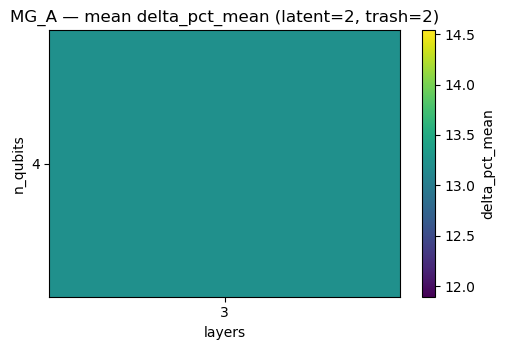

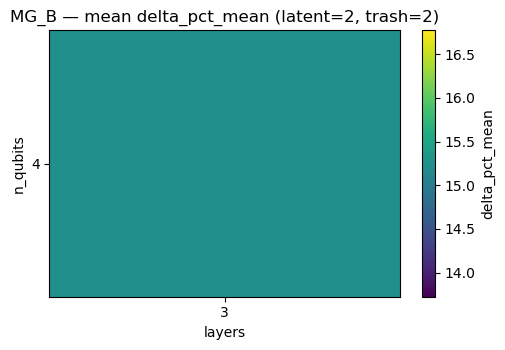

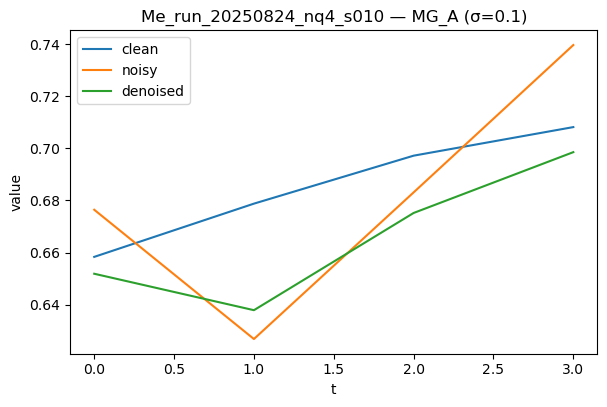

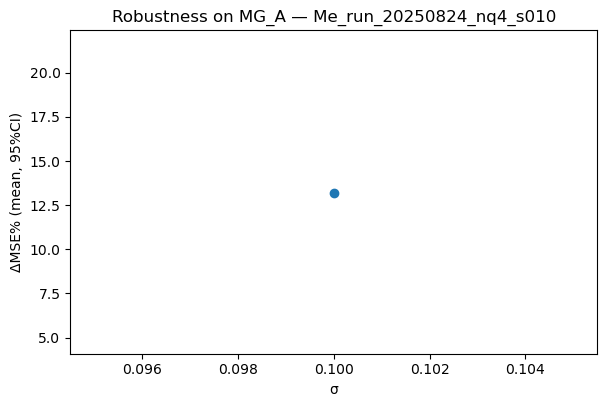

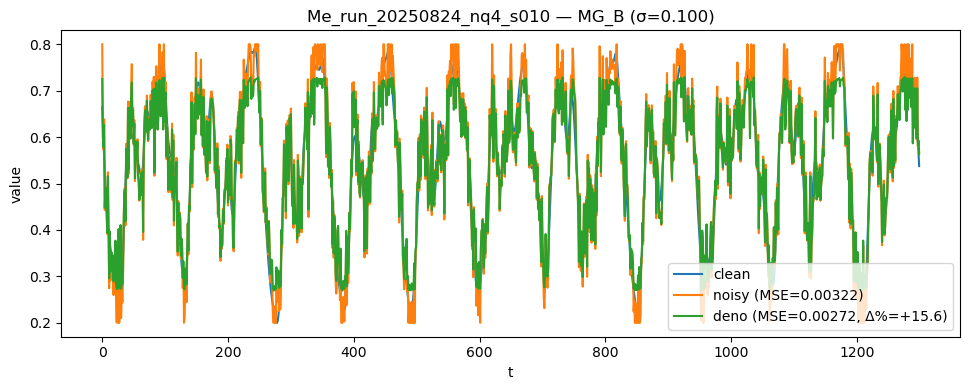

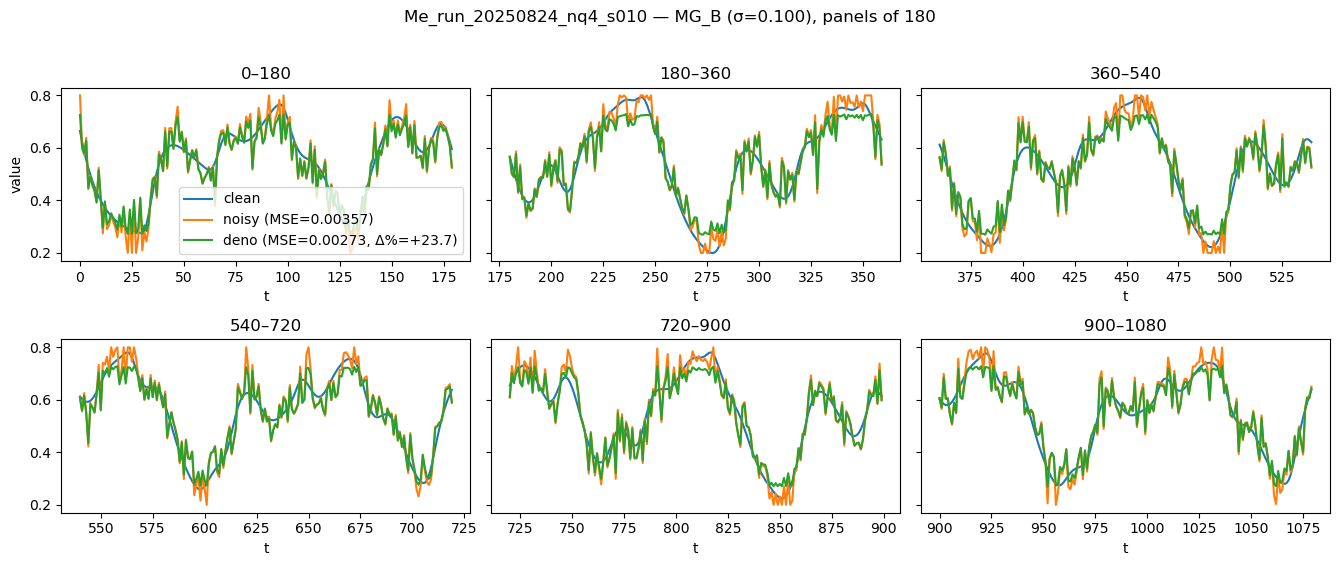

MG_B | Me_run_20250824_nq4_s010 | σ=0.100
Global MSE: noisy=0.00322 deno=0.00272 Δ%=+15.6
Samples improved: 64.5%


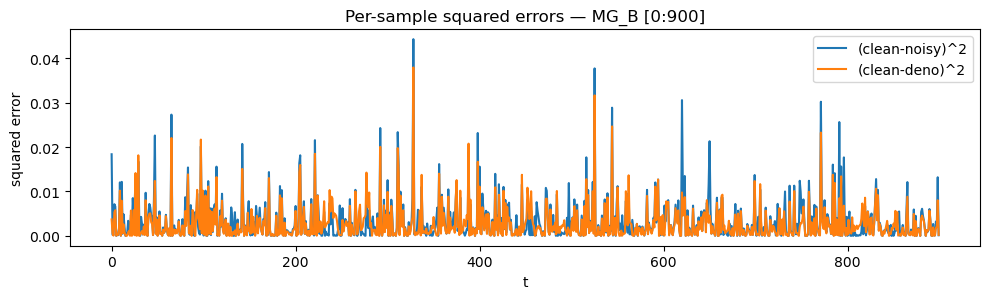

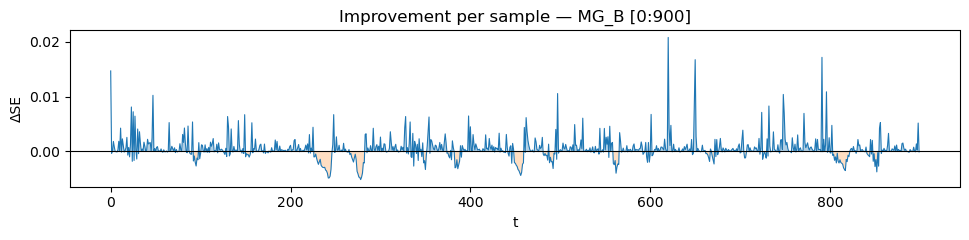

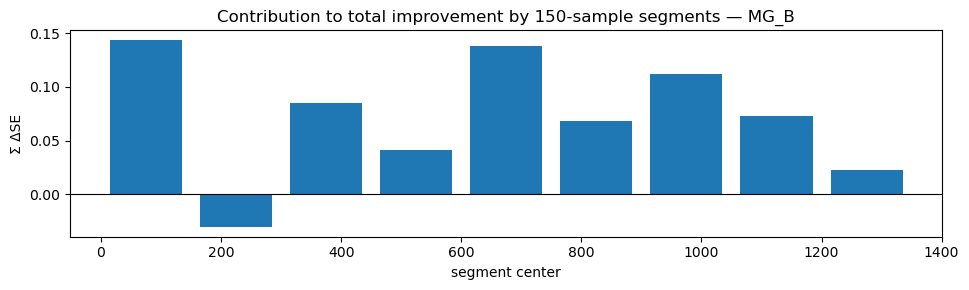

In [88]:
# === Cell 8 — Load models & standard analyses ===============================
REG = load_models_sidekick(MODEL_PATHS)

ALL_RESULTS, ALL_SUMMARIES = run_benchmark(REG, n_eval=N_EVAL_WINDOWS, sigma_override=EVAL_SIGMA)

# Table + quick heatmaps
if REG:
    df = summaries_to_df(ALL_SUMMARIES, REG)
    print("\n== Summary (head) ==")
    print(df.head(12).to_string(index=False))

    for dsname in sorted(ALL_SUMMARIES):
        heatmap_by_arch(df, dsname, value_col="delta_pct_mean")

    # Show a few visuals per window size (first model hitting that size)
    shown=set()
    for name, entry in REG.items():
        w = entry.n_qubits
        if w in shown: continue
        dsname = "MG_A"
        er = ALL_RESULTS[dsname][name]
        plot_reconstruction_example(er, idx=0, title=f"{name} — {dsname} (σ={'model' if EVAL_SIGMA=='model' else EVAL_SIGMA})")
        plot_robustness(entry, DATASETS_BY_W[w][dsname], sigmas=(0.10,), n_eval=N_EVAL_WINDOWS)
        # Full series & panels on MG_B
        rec = reconstruct_full_series(entry, DATASETS_BY_W[w]["MG_B"], sigma_override=EVAL_SIGMA)
        plot_full_series(rec, title=f"{name} — MG_B (σ={rec['sigma']:.3f})")
        plot_full_series_panels(entry, DATASETS_BY_W[w]["MG_B"], sigma_override=EVAL_SIGMA,
                                panel_len=180, ncols=3, nrows=2, start=0, sharey=True)
        error_lens(entry, DATASETS_BY_W[w]["MG_B"], sigma_override=EVAL_SIGMA, seg=150, start=0, length=900)
        shown.add(w)